## Importo librerías

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from pandasql import sqldf
%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
!pip install geopandas

In [3]:
!pip install requests

In [4]:
# Si se está en google colab, reemplazar por path de Drive
data_path = 'C:/Users/Usuario/Documents/GitHub/enmodo/'

In [5]:
import sys

# Si se está en google colab, reemplazar por path donde tiene la carpeta "scripts"
sys.path.insert(1, data_path +'scripts')

import eod_analysis as eod

## Google colab

Para ejecutar este notebook en Colab, primero descomenten y ejecuten las siguientes 3 celdas. Luego de ejecutar la notebook se reiniciará.

In [6]:
'''
# Montando datos desde Google Drive
from google.colab import drive
drive.mount('/content/drive')
'''

"\n# Montando datos desde Google Drive\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [7]:
'''
import sys
sys.path.append('/aqui_reemplazar_path_drive/')
'''

"\nimport sys\nsys.path.append('/aqui_reemplazar_path_drive/')\n"

### Levanto ENMODO 2009
https://www.argentina.gob.ar/transporte/dgppse/publicaciones/encuestas

Esta notebook apunta directamente a datos subidos a github por lo cual no es necesario reemplazarla por data paths locales o en drive

In [8]:
hogares = pd.read_csv('https://media.githubusercontent.com/media/RacoFernandez/enmodo/main/buenos-aires/source-csv/hogares.csv')
personas = pd.read_csv('https://media.githubusercontent.com/media/RacoFernandez/enmodo/main/buenos-aires/source-csv/personas.csv')
viajes = pd.read_csv('https://media.githubusercontent.com/media/RacoFernandez/enmodo/main/buenos-aires/source-csv/viajes.csv')
etapas = pd.read_csv('https://media.githubusercontent.com/media/RacoFernandez/enmodo/main/buenos-aires/source-csv/etapas.csv')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11788\444273230.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  viajes = pd.read_csv('https://media.githubusercontent.com/media/RacoFernandez/enmodo/main/buenos-aires/source-csv/viajes.csv')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_11788\444273230.py:4: DtypeWarning: Columns (24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  etapas = pd.read_csv('https://media.githubusercontent.com/media/RacoFernandez/enmodo/main/buenos-aires/source-csv/etapas.csv')


### Caracterización de los datos

Los datos utilizados en este cuaderno corresponden a los resultados de la Encuesta Origen-Destino de Buenos Aires (AMBA), Argentina del 2009. 
A partir de estos datos se calcularan indicadores en tres niveles: de Cantidad de Viajes, de Tiempo de Viajes, y de Distancia de Viajes.

Hay datos a nivel hogares, personas, viajes y etapas.

### Importando datos

In [9]:
import requests
import json
datastring = "https://raw.githubusercontent.com/RacoFernandez/enmodo/main/buenos-aires/source-geojson/departamentos-buenos_aires.json"
resp = requests.get(datastring)
departamentos = json.loads(resp.text)

In [10]:
datastring = "https://raw.githubusercontent.com/RacoFernandez/enmodo/main/buenos-aires/source-geojson/departamentos-ciudad_autonoma_de_buenos_aires.json"
resp = requests.get(datastring)
departamentos_caba = json.loads(resp.text)

In [11]:
import geopandas as gpd
departamentos_gpd = gpd.GeoDataFrame.from_features(departamentos["features"])

C:\Users\Usuario\anaconda3\envs\enmodo\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


In [12]:
departamentos_gpd.departamento.unique()

array(['ALMIRANTE BROWN', 'LA PLATA', 'PRESIDENTE PERON',
       'CARLOS CASARES', 'SALADILLO', 'PEHUAJO', 'TRENQUE LAUQUEN',
       'GENERAL BELGRANO', 'LAS FLORES', 'GENERAL GUIDO', 'OLAVARRIA',
       'ROJAS', 'SAN ANTONIO DE ARECO', 'MAIPU', 'ARRECIFES',
       'CAPITAN SARMIENTO', 'CARMEN DE ARECO', 'PINAMAR', 'SALTO',
       'EXALTACION DE LA CRUZ', 'ESCOBAR', 'SAN MIGUEL',
       'SAN ANDRES DE GILES', 'JUNIN', 'MERCEDES', 'GENERAL VILLEGAS',
       'PILAR', 'LUJAN', 'HURLINGHAM', 'MORON', 'CHACABUCO',
       'MALVINAS ARGENTINAS', 'JOSE C PAZ', 'GENERAL SAN MARTIN',
       'MORENO', 'LINCOLN', 'ITUZAINGO', 'FLORENTINO AMEGHINO',
       'LA MATANZA', 'GENERAL RODRIGUEZ', 'SUIPACHA', 'TRES DE FEBRERO',
       'MERLO', 'CHIVILCOY', 'BRAGADO', 'LANUS', 'GENERAL LAS HERAS',
       'MARCOS PAZ', 'LOMAS DE ZAMORA', 'GENERAL VIAMONTE',
       'ESTEBAN ECHEVERRIA', 'EZEIZA', 'ALBERTI', 'FLORENCIO VARELA',
       'NAVARRO', 'CAÑUELAS', 'SAN VICENTE', 'LOBOS', 'BRANDSEN',
       'CARLOS T

## Limpieza de la capa de departamentos y join con datos de viajes de ENMODO (ya que la misma no viene con la data de la geometría de los viajes)

In [13]:
# Me quedo solo con algunos departamentos (los presentes en la ENMODO 2009)
departamentos_amba_gpd = departamentos_gpd[(departamentos_gpd['departamento'].str.contains("BROWN"))|
                  (departamentos_gpd['departamento'].str.contains("MATANZA"))|
                  (departamentos_gpd['departamento'].str.contains("LOPEZ"))|
                  (departamentos_gpd['departamento'].str.contains("ECHEVERRIA"))|
                  (departamentos_gpd['departamento'].str.contains("MORON"))|
                  (departamentos_gpd['departamento'].str.contains("ISIDRO"))|
                  (departamentos_gpd['departamento'].str.contains("PILAR"))|
                  (departamentos_gpd['departamento'].str.contains("LANUS"))|
                  (departamentos_gpd['departamento'].str.contains("JOSE C PAZ"))|
                  (departamentos_gpd['departamento'].str.contains("QUILMES"))|
                  (departamentos_gpd['departamento'].str.contains("HURLINGHAM"))|
                  (departamentos_gpd['departamento'].str.contains("SAN MARTIN"))|
                  (departamentos_gpd['departamento'].str.contains("AVELLANEDA"))|
                  (departamentos_gpd['departamento'].str.contains("LOMAS DE ZAMORA"))|
                  (departamentos_gpd['departamento'].str.contains("BERAZATEGUI"))|
                  (departamentos_gpd['departamento'].str.contains("ITUZAINGO"))|
                  (departamentos_gpd['departamento'].str.contains("ESCOBAR"))|
                  (departamentos_gpd['departamento'].str.contains("SAN MIGUEL"))|
                  (departamentos_gpd['departamento'].str.contains("MERLO"))|
                  (departamentos_gpd['departamento'].str.contains("FEBRERO"))|
                  (departamentos_gpd['departamento'].str.contains("SAN FERNANDO"))|
                  (departamentos_gpd['departamento'].str.contains("MORENO"))|
                  (departamentos_gpd['departamento'].str.contains("EZEIZA"))|
                  (departamentos_gpd['departamento'].str.contains("MALVINAS"))|
                  (departamentos_gpd['departamento'].str.contains("TIGRE"))|
                  (departamentos_gpd['departamento'].str.contains("PERON"))|
                  (departamentos_gpd['departamento'].str.contains("LA PLATA"))|
                  (departamentos_gpd['departamento'].str.contains("CAÑUELAS"))|
                  (departamentos_gpd['departamento'].str.contains("GENERAL LAS HERAS"))|
                  (departamentos_gpd['departamento'].str.contains("ZARATE"))|
                  (departamentos_gpd['departamento'].str.contains("MARCOS PAZ"))|
                  (departamentos_gpd['departamento'].str.contains("BRANDSEN"))|
                  (departamentos_gpd['departamento'].str.contains("ENSENADA"))|
                  (departamentos_gpd['departamento'].str.contains("MERCEDES"))|
                  (departamentos_gpd['departamento'].str.contains("BERISSO"))|
                  (departamentos_gpd['departamento'].str.contains("SAN VICENTE"))|
                  (departamentos_gpd['departamento'].str.contains("GENERAL RODRIGUEZ"))|
                  (departamentos_gpd['departamento'].str.contains("EXALTACION DE LA CRUZ"))|
                  (departamentos_gpd['departamento'].str.contains("FLORENCIO"))]

In [14]:
del(departamentos_gpd)

In [15]:
departamentos_caba_gpd = gpd.GeoDataFrame.from_features(departamentos_caba["features"])

In [16]:
del(departamentos_caba)

In [17]:
departamentos_amba_gpd = departamentos_amba_gpd.append(departamentos_caba_gpd)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11788\2415365610.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  departamentos_amba_gpd = departamentos_amba_gpd.append(departamentos_caba_gpd)


In [18]:
viajes.partido = viajes.partido.str.upper()

In [19]:
viajes.TT_PARTIDO_ORIGEN = viajes.TT_PARTIDO_ORIGEN.str.upper()

In [20]:
viajes.TT_PARTIDO_DESTINO = viajes.TT_PARTIDO_DESTINO.str.upper()

In [21]:
cols = viajes.select_dtypes(include=[np.object]).columns
viajes[cols] = viajes[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11788\1910569586.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cols = viajes.select_dtypes(include=[np.object]).columns


In [22]:
dict = {"ALTE. BROWN" : 'ALMIRANTE BROWN', "E. ECHEVERRIA": 'ESTEBAN ECHEVERRIA', "JOSE C. PAZ": 'JOSE C PAZ',
         "PTE. PERON": 'PRESIDENTE PERON', "CORONEL BRANDSEN": 'BRANDSEN', "CANUELAS": 'CAÑUELAS', "SOLDATI": 'VILLA SOLDATI',
        "NUNEZ": 'NUÑEZ'}
viajes=viajes.replace({"partido": dict, "TT_PARTIDO_ORIGEN": dict, "TT_PARTIDO_DESTINO": dict})

In [23]:
barrios_caba = pd.read_csv('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.csv')

In [24]:
viajes = viajes.merge(barrios_caba, left_on='TT_LOCALIDAD_ORIGEN', right_on='barrio', how='left')

In [25]:
viajes.pop("WKT")
viajes.pop("barrio")
viajes.pop("perimetro")
viajes.pop("area")

0                  NaN
1         2.289008e+06
2         2.043711e+06
3         4.342280e+06
4                  NaN
              ...     
102779             NaN
102780    7.398179e+06
102781    7.398179e+06
102782    8.590784e+06
102783    2.289008e+06
Name: area, Length: 102784, dtype: float64

In [26]:
viajes = viajes.merge(barrios_caba, left_on='TT_LOCALIDAD_DESTINO', right_on='barrio', how='left')

In [27]:
viajes.pop("WKT")
viajes.pop("barrio")
viajes.pop("perimetro")
viajes.pop("area")

0         2.289008e+06
1         2.043711e+06
2         4.342280e+06
3                  NaN
4                  NaN
              ...     
102779             NaN
102780    2.289008e+06
102781    2.198622e+06
102782             NaN
102783             NaN
Name: area, Length: 102784, dtype: float64

In [28]:
viajes = viajes.rename(columns={'comuna_x': 'comuna_origen', 'comuna_y': 'comuna_destino'})

In [29]:
viajes.comuna_origen.fillna(viajes.TT_PARTIDO_ORIGEN, inplace = True)

In [30]:
viajes.comuna_destino.fillna(viajes.TT_PARTIDO_DESTINO, inplace = True)

In [31]:
viajes.comuna_origen = viajes.comuna_origen.astype(str)

In [32]:
viajes.comuna_destino = viajes.comuna_destino.astype(str)

In [33]:
viajes.comuna_origen.unique()

array(['LA MATANZA', '1.0', '3.0', 'ALMIRANTE BROWN', '2.0',
       'VICENTE LOPEZ', 'SAN ISIDRO', 'CAMPANA', 'TIGRE',
       'LOMAS DE ZAMORA', 'MORON', '4.0', '13.0', 'SAN FERNANDO', '14.0',
       '6.0', '15.0', 'MORENO', '12.0', 'GENERAL SAN MARTIN', '11.0',
       'LANUS', 'EZEIZA', '9.0', 'MERLO', '5.0', '10.0',
       'ESTEBAN ECHEVERRIA', '7.0', 'LA PLATA', 'CAP. FED. DE 19', '8.0',
       'ITUZAINGO', 'TRES DE FEBRERO', 'PILAR', 'JOSE C PAZ',
       'SAN MIGUEL', 'AVELLANEDA', 'GENERAL RODRIGUEZ', 'QUILMES',
       'FLORENCIO VARELA', 'HURLINGHAM', 'CAP. FED. DE 21',
       'FUERA DE AREA - NORTE', 'BERAZATEGUI', 'ESCOBAR', 'LUJAN',
       'MALVINAS ARGENTINAS', 'SIN DATO', 'FUERA DE AREA - SUR',
       'SAN VICENTE', 'CAÑUELAS', 'GENERAL LAS HERAS', 'PRESIDENTE PERON',
       'ZARATE', 'MARCOS PAZ', 'BRANDSEN', 'CAP. FED. DE 10', 'ENSENADA',
       'EXALTACION DE LA CRUZ', 'BERISSO', 'MERCEDES'], dtype=object)

In [34]:
dict = {"1.0" : 'COMUNA 1', "2.0" : 'COMUNA 2', "3.0" : 'COMUNA 3', "4.0" : 'COMUNA 4',
        "5.0" : 'COMUNA 5', "6.0" : 'COMUNA 6', "7.0" : 'COMUNA 7', "8.0" : 'COMUNA 8',
        "9.0" : 'COMUNA 9', "10.0" : 'COMUNA 10', "11.0" : 'COMUNA 11', "12.0" : 'COMUNA 12',
        "13.0" : 'COMUNA 13', "14.0" : 'COMUNA 14', "15.0" : 'COMUNA 15'}
viajes=viajes.replace({"comuna_origen": dict, "comuna_destino": dict})

In [35]:
viajes_gpd = departamentos_amba_gpd.merge(viajes, left_on = 'departamento', right_on='comuna_origen', how='right')

In [36]:
viajes_gpd = viajes_gpd.merge(departamentos_amba_gpd, left_on = 'comuna_destino', right_on = 'departamento', how='left')

In [37]:
viajes_gpd = viajes_gpd.rename(columns={'geometry_x': 'geometry_origen', 'geometry_y': 'geometry_destino'})

In [38]:
viajes_gpd.pop("id_x")
viajes_gpd.pop("departamento_x")
viajes_gpd.pop("cabecera_x")
viajes_gpd.pop("provincia_x")
viajes_gpd.pop("id_y")
viajes_gpd.pop("departamento_y")
viajes_gpd.pop("cabecera_y")
viajes_gpd.pop("provincia_y")

0         CIUDAD AUTONOMA DE BUENOS AIRES
1         CIUDAD AUTONOMA DE BUENOS AIRES
2         CIUDAD AUTONOMA DE BUENOS AIRES
3                            BUENOS AIRES
4                            BUENOS AIRES
                       ...               
102779                       BUENOS AIRES
102780    CIUDAD AUTONOMA DE BUENOS AIRES
102781    CIUDAD AUTONOMA DE BUENOS AIRES
102782                       BUENOS AIRES
102783                       BUENOS AIRES
Name: provincia_y, Length: 102784, dtype: object

In [39]:
viajes_gpd = viajes_gpd.set_geometry("geometry_origen")

In [40]:
viajes_gpd['origen_x_coord'] = viajes_gpd['geometry_origen'].centroid.x
viajes_gpd['origen_y_coord'] = viajes_gpd['geometry_origen'].centroid.y

C:\Users\Usuario\anaconda3\envs\enmodo\lib\site-packages\geopandas\array.py:524: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return _unary_geo("centroid", self)
C:\Users\Usuario\anaconda3\envs\enmodo\lib\site-packages\geopandas\geoseries.py:133: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = from_shapely(s.values)
C:\Users\Usuario\anaconda3\envs\enmodo\lib\site-packages\geopandas\array.py:524: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return _unary_geo("centroid", self)
C:\Users\Usuario\anaconda3\envs\enmodo\lib\site-packages\geopandas\geoseries.py:133: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the 

In [41]:
viajes_gpd = viajes_gpd.set_geometry("geometry_destino")

In [42]:
viajes_gpd['destino_x_coord'] = viajes_gpd['geometry_destino'].centroid.x
viajes_gpd['destino_y_coord'] = viajes_gpd['geometry_destino'].centroid.y

C:\Users\Usuario\anaconda3\envs\enmodo\lib\site-packages\geopandas\array.py:524: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return _unary_geo("centroid", self)
C:\Users\Usuario\anaconda3\envs\enmodo\lib\site-packages\geopandas\geoseries.py:133: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = from_shapely(s.values)
C:\Users\Usuario\anaconda3\envs\enmodo\lib\site-packages\geopandas\array.py:524: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return _unary_geo("centroid", self)
C:\Users\Usuario\anaconda3\envs\enmodo\lib\site-packages\geopandas\geoseries.py:133: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the 

In [43]:
# filtro viajes sin origen o destino especificado
viajes_gpd = viajes_gpd[(viajes_gpd.comuna_origen != 'FUERA DE AREA - NORTE')&(viajes_gpd.comuna_origen != 'FUERA DE AREA - SUR')&(viajes_gpd.comuna_origen != 'SIN DATO')&
            (viajes_gpd.comuna_destino != 'FUERA DE AREA - NORTE')&(viajes_gpd.comuna_destino != 'FUERA DE AREA - SUR')&(viajes_gpd.comuna_destino != 'SIN DATO')]

## Modo

In [44]:
etapas['Modo'] = etapas['Modo'].replace(['Ferrocarril', 'Subte / Premetro', 'A pie', 'Automovil / conductor', 'Taxi', 'Automovil / acompañante',
       'Colectivo', 'Bicicleta', 'Remis', 'Charter / combi', 'Bus empresa', 'Motocicleta', 'Otros', 'Transporte escolar', 'Lancha Colectiva'],
        ['Ferrocarril', 'Subte/Premetro', 'A pie', 'Automovil/conductor', 'Taxi', 'Automovil/acompañante', 'Colectivo', 'Bicicleta', 'Remis', 'Charter/combi',
       'Bus empresa', 'Motocicleta', 'Otros', 'Transporte escolar', 'Lancha Colectiva'])

In [45]:
# Creo sub-categorías de agrupación en Etapas

etapas_cats_old = ['Ferrocarril', 'Subte/Premetro', 'A pie', 'Automovil/conductor', 'Taxi', 'Automovil/acompañante', 'Colectivo', 'Bicicleta',
               'Remis', 'Charter/combi', 'Bus empresa', 'Motocicleta', 'Otros', 'Transporte escolar', 'Lancha Colectiva']
etapas_cats_new = ['Público', 'Público', 'No Motorizado', 'Auto/Moto', 'A demanda', 'Auto/Moto', 'Público', 'No Motorizado',
               'A demanda', 'A demanda', 'A demanda', 'Auto/Moto', 'A demanda', 'A demanda', 'A demanda']


etapas['Modo_agg'] = etapas['Modo'].replace(etapas_cats_old, etapas_cats_new)

# Creo variables dummies para agregación de etapas a nivel de viaje
etapas = pd.concat([etapas, pd.get_dummies(etapas.Modo)], axis=1)
etapas = pd.concat([etapas, pd.get_dummies(etapas.Modo_agg)], axis=1)

In [46]:
particion_etapas = etapas.groupby(['Modo', 'Modo_agg']).wt1.sum().round().astype(int).reset_index()
particion_etapas.columns = ['Modo', 'Modo_agg', 'Etapas']
particion_etapas['Etapas_porc'] = (particion_etapas.Etapas / particion_etapas.Etapas.sum() * 100).round(1)

### Ahora en tabla viajes

In [47]:
etapas.columns

Index(['Unnamed: 0', 'fraccion', 'partido', 'LOCALIDA', 'ETAPANUM', 'MOTIVOCA',
       'ESTENT', 'ESTSAL', 'TARIFABO', 'TIPOTARI', 'TIPOGARA', 'TIPOCOST',
       'COSTOPEA', 'COSTOTAX', 'CUACAANT', 'CUACADES', 'Modo', 'COSTOEST',
       'ESTACENT', 'ESTACSAL', 'LINEAENT', 'LINEASAL', 'ESTACSUB', 'ESTACBAJ',
       'ESPEHORA', 'ESPEMINU', 'DURAHORA', 'DURAMINU', 'TAXICOM',
       'Z_TXTLINEA_NUMERICO', 'Z_TXTLINEA_SIN_CODIGO', 'wt1', 'z_tarifabo2',
       'z_frecuenc_imput', 'z_costota2_2', 'z_costopea', 'z_COSTOEST', 'IDH',
       'IDP', 'IDV', 'IDE', 'Modo_agg', 'A pie', 'Automovil/acompañante',
       'Automovil/conductor', 'Bicicleta', 'Bus empresa', 'Charter/combi',
       'Colectivo', 'Ferrocarril', 'Lancha Colectiva', 'Motocicleta', 'Otros',
       'Remis', 'Subte/Premetro', 'Taxi', 'Transporte escolar', 'A demanda',
       'Auto/Moto', 'No Motorizado', 'Público'],
      dtype='object')

In [48]:
viajes_gpd_etapa = viajes_gpd.merge(etapas, on = 'IDV', how='left')

In [49]:
viajes_gpd_etapa = viajes_gpd_etapa.merge(personas, left_on = 'IDP_x', right_on = 'IDP', how='left')

In [50]:
viajes_gpd = viajes_gpd.merge(personas, on = 'IDP', how='left')

In [51]:
'''
# Otra alternativa podría ser:
Viajes_agg = etapas.groupby(['IDH', 'IDP', 'IDV']).agg({'Modo':'max', 'modo_agg':'max', 'Ferrocarril':'sum', 'Subte/Premetro':'sum', 'A pie':'sum', 'Automovil/conductor':'sum', 'Taxi':'sum', 
                                                  'Automovil/acompañante':'sum', 'Colectivo':'sum', 'Bicicleta':'sum', 'Remis':'sum', 'Charter/combi':'sum', 
                                                  'Bus empresa':'sum', 'Motocicleta':'sum', 'Otros':'sum', 'Transporte escolar':'sum', 'Lancha Colectiva':'sum', 
                                                  'Público':'sum', 'No Motorizado':'sum', 'Auto/Moto':'sum', 'A demanda':'sum', 'wt1':'max'}).reset_index()

Viajes_agg['Cant_etapas'] = Viajes_agg[['Público', 'No Motorizado', 'Auto/Moto', 'A demanda']].sum(axis=1)
Viajes_agg.loc[(Viajes_agg.Cant_etapas>1)&(Viajes_agg.Público>0), 'Modo'] = 'Multietapa'
Viajes_agg.loc[(Viajes_agg.Cant_etapas>1)&((Viajes_agg.Modo!='Multietapa')), 'Modo'] = 'Otros Multietapa'
Viajes_agg.loc[Viajes_agg.Modo=='Otros Multietapa', 'Modo_agg'] = 'Otros Multietapa'
Viajes_agg.loc[Viajes_agg.Modo=='Multietapa', 'Modo_agg'] = 'Multietapa'

Viajes_agg['Modo_agg2'] = Viajes_agg.Modo_agg.replace(['No Motorizado', 'Auto/Moto', 'A demanda', 'Público',
       'Otros Multietapa', 'Multietapa'], ['No Motorizado', 'Auto/Moto', 'A demanda', 'Público',
       'A demanda', 'Público'])
'''

"\n# Otra alternativa podría ser:\nViajes_agg = etapas.groupby(['IDH', 'IDP', 'IDV']).agg({'Modo':'max', 'modo_agg':'max', 'Ferrocarril':'sum', 'Subte/Premetro':'sum', 'A pie':'sum', 'Automovil/conductor':'sum', 'Taxi':'sum', \n                                                  'Automovil/acompañante':'sum', 'Colectivo':'sum', 'Bicicleta':'sum', 'Remis':'sum', 'Charter/combi':'sum', \n                                                  'Bus empresa':'sum', 'Motocicleta':'sum', 'Otros':'sum', 'Transporte escolar':'sum', 'Lancha Colectiva':'sum', \n                                                  'Público':'sum', 'No Motorizado':'sum', 'Auto/Moto':'sum', 'A demanda':'sum', 'wt1':'max'}).reset_index()\n\nViajes_agg['Cant_etapas'] = Viajes_agg[['Público', 'No Motorizado', 'Auto/Moto', 'A demanda']].sum(axis=1)\nViajes_agg.loc[(Viajes_agg.Cant_etapas>1)&(Viajes_agg.Público>0), 'Modo'] = 'Multietapa'\nViajes_agg.loc[(Viajes_agg.Cant_etapas>1)&((Viajes_agg.Modo!='Multietapa')), 'Modo'] = 'Otros

## Cálculo distancia

In [52]:
def manhattan_distance(a, b):
    return sum(abs(e1-e2) for e1, e2 in zip(a,b)) * 100

In [53]:
def distance_calc (row):
    start = (row['origen_y_coord'], row['origen_x_coord'])
    stop = (row['destino_y_coord'], row['destino_x_coord'])

    return manhattan_distance(start, stop)

In [54]:
viajes_gpd['distance'] = viajes_gpd.apply (lambda row: distance_calc (row),axis=1)

In [55]:
viajes_gpd_etapa['distance'] = viajes_gpd_etapa.apply (lambda row: distance_calc (row),axis=1)

## Cálculo de tiempo

In [56]:
def time_difference(row):
  if row['HORALLEG'] == 99999.0:
    return(0)
  elif((row['HORALLEG'] >= 0) and (row['HORASALI'] <= 23 and row['HORASALI'] >=19)):
    time_diff = (24 - row['HORASALI']) * 60 + (row['MINLLEGA'] - row['MINSALID'])
  elif(row['HORALLEG'] == 1 and (row['HORASALI'] <= 23 and row['HORASALI'] >= 19)):
    time_diff = (25 - row['HORASALI']) * 60 + (row['MINLLEGA'] - row['MINSALID'])
  else:
    time_diff = (row['HORALLEG'] - row['HORASALI']) * 60 + (row['MINLLEGA'] - row['MINSALID'])
  return(time_diff)

In [57]:
viajes_gpd['time_diff'] = viajes_gpd.apply (lambda row: time_difference (row),axis=1)

In [58]:
viajes_gpd_etapa['time_diff'] = viajes_gpd_etapa.apply (lambda row: time_difference (row),axis=1)

In [59]:
viajes_gpd = viajes_gpd[viajes_gpd.time_diff>0]

In [60]:
viajes_gpd_etapa = viajes_gpd_etapa[viajes_gpd_etapa.time_diff>0]

## Horario punta

In [61]:
def tipo_horario(row):
    if (row['HORASALI'] >= 7.0 and row['HORASALI'] < 11) or (row['HORASALI'] >= 16 and row['HORASALI'] < 20) :
        return 'punta'
    else:
        return 'valle'

In [62]:
viajes_gpd['tipo_horario'] = viajes_gpd.apply(tipo_horario, axis=1)

In [63]:
viajes_gpd_etapa['tipo_horario'] = viajes_gpd_etapa.apply(tipo_horario, axis=1)

## Horario punta mañana

In [64]:
def tipo_horario_punta_manana(row):
    if (row['HORASALI'] >= 7.0 and row['HORASALI'] < 11) :
        return True
    else:
        return False

In [65]:
viajes_gpd['punta_manana'] = viajes_gpd.apply(tipo_horario_punta_manana, axis=1)

In [66]:
viajes_gpd_etapa['punta_manana'] = viajes_gpd_etapa.apply(tipo_horario_punta_manana, axis=1)

## Recategorizo modo para el posterior calculo de indicadores

In [67]:
viajes_gpd_etapa['Modo_indicador'] = viajes_gpd_etapa['Modo']

In [68]:
dict = {"Automovil/acompañante" : 'Auto', "Automovil/conductor": 'Auto', "Bus empresa": 'Otros',
         "Charter/combi": 'Otros', "Colectivo": 'Público', "Ferrocarril": 'Público', "Lancha Colectiva": 'Público',
        "Remis": 'Otros', "Subte/Premetro": 'Público', "Taxi": 'Otros', "Transporte escolar": 'Otros'}

viajes_gpd_etapa=viajes_gpd_etapa.replace({"Modo_indicador": dict})

In [69]:
# Cambio valores lugar de trabajo
viajes_gpd['ACTIORIG_AGG'] = viajes_gpd['ACTIORIG'] 
dict = {'Asunto laboral': 'Trabajo', 'Lugar de trabajo': 'Trabajo'}
viajes_gpd=viajes_gpd.replace({"ACTIORIG_AGG": dict})
viajes_gpd_etapa['ACTIORIG_AGG'] = viajes_gpd_etapa['ACTIORIG'] 
viajes_gpd_etapa=viajes_gpd_etapa.replace({"ACTIORIG_AGG": dict})

## Join de Viajes - Etapa + Hogares

In [70]:
viajes_gpd_etapa_hogares = viajes_gpd_etapa.merge(hogares, on = 'IDH', how='left')

C:\Users\Usuario\anaconda3\envs\enmodo\lib\site-packages\geopandas\geodataframe.py:577: FutureWarning: Passing 'suffixes' which cause duplicate columns {'wt1_x', 'fraccion_x', 'Unnamed: 0_x', 'LOCALIDA_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


In [71]:
viajes_gpd_hogares = viajes_gpd.merge(hogares, left_on = 'IDH_x', right_on = 'IDH', how='left')

## Cálculo de indicadores

### Con factor de expansión

In [ ]:
viajes_gpd_etapa.wt1.sum()

In [ ]:
viajes_gpd_etapa.groupby(['Modo_agg']).agg({"wt1" : "sum"})[["wt1"]]

In [ ]:
viajes_gpd_etapa.groupby(['SEXO']).agg({"wt1" : "sum"})[["wt1"]]

In [ ]:
viajes_gpd_etapa.groupby(['ACTIORIG_AGG']).agg({"wt1" : "sum"})[["wt1"]]

#### Distancia de viajes en automóvil privado + Distancia de viajes en transporte público

In [ ]:
def weighted_mean(df, value_column, weighs_column):
    weighted_sum = (df[value_column] * df[weighs_column]).sum()
    return weighted_sum / df[weighs_column].sum()

In [ ]:
def weighted_median(df, val, weight):
    df_sorted = df.sort_values(val)
    cumsum = df_sorted[weight].cumsum()
    cutoff = df_sorted[weight].sum() / 2.
    return df_sorted[cumsum >= cutoff][val].iloc[0]

In [ ]:
viajes_gpd_etapa.groupby(["Modo_agg"]).apply(lambda x: weighted_median(x, 'distance', 'wt1'))

In [ ]:
viajes_gpd_etapa.groupby(["Modo_agg", 'SEXO']).apply(lambda x: weighted_median(x, 'distance', 'wt1')).unstack()

#### Distancia de viajes por motivo estudio + Distancia de viajes por motivo trabajo

In [ ]:
viajes_gpd_etapa.groupby(["ACTIORIG_AGG"]).apply(lambda x: weighted_median(x, 'distance', 'wt1'))

In [ ]:
viajes_gpd_etapa.groupby(['ACTIORIG_AGG', 'SEXO']).apply(lambda x: weighted_median(x, 'distance', 'wt1')).unstack()

#### Proporción de viajes intrazonales versus interzonales

In [ ]:
viajes_gpd["es_caba_origen"] = viajes_gpd["comuna_origen"].str.contains("COMUNA")

In [ ]:
viajes_gpd["es_caba_destino"] = viajes_gpd["comuna_destino"].str.contains("COMUNA")

In [ ]:
viajes_gpd.loc[((viajes_gpd['es_caba_origen'] == True) & (viajes_gpd['es_caba_destino'] == True)) |
               ((viajes_gpd['es_caba_origen'] == False) & (viajes_gpd['es_caba_destino'] == False)), 'tipo_viaje_zona'] = 'Intrazonal'  

In [ ]:
viajes_gpd.loc[((viajes_gpd['es_caba_origen'] == True) & (viajes_gpd['es_caba_destino'] == False)) |
               ((viajes_gpd['es_caba_origen'] == False) & (viajes_gpd['es_caba_destino'] == True)), 'tipo_viaje_zona'] = 'Interzonal'  

In [ ]:
viajes_gpd_etapa["es_caba_origen"] = viajes_gpd_etapa["comuna_origen"].str.contains("COMUNA")

In [ ]:
viajes_gpd_etapa["es_caba_destino"] = viajes_gpd_etapa["comuna_destino"].str.contains("COMUNA")

In [ ]:
viajes_gpd_etapa.loc[((viajes_gpd_etapa['es_caba_origen'] == True) & (viajes_gpd_etapa['es_caba_destino'] == True)) |
               ((viajes_gpd_etapa['es_caba_origen'] == False) & (viajes_gpd_etapa['es_caba_destino'] == False)), 'tipo_viaje_zona'] = 'Intrazonal'

In [ ]:
viajes_gpd_etapa.loc[((viajes_gpd_etapa['es_caba_origen'] == True) & (viajes_gpd_etapa['es_caba_destino'] == False)) |
               ((viajes_gpd_etapa['es_caba_origen'] == False) & (viajes_gpd_etapa['es_caba_destino'] == True)), 'tipo_viaje_zona'] = 'Interzonal' 

In [ ]:
viajes_gpd_etapa.groupby('tipo_viaje_zona').wt1.sum()

#### Tiempo promedio de viaje al trabajo en transporte público


In [ ]:
viajes_gpd_etapa.groupby(["Modo_agg"]).apply(lambda x: weighted_median(x, 'time_diff', 'wt1'))

In [ ]:
viajes_gpd_etapa.groupby(["Modo_agg", "SEXO"]).apply(lambda x: weighted_median(x, 'time_diff', 'wt1')).unstack()

#### Tiempo promedio de viaje en hora punta de mañana

In [ ]:
viajes_gpd_etapa.groupby(["tipo_horario"]).apply(lambda x: weighted_median(x, 'time_diff', 'wt1'))

In [ ]:
viajes_gpd_etapa.groupby(["tipo_horario", "SEXO"]).apply(lambda x: weighted_median(x, 'time_diff', 'wt1')).unstack()

#### Tiempo de viaje en transporte público en hora punta en la mañana


In [ ]:
viajes_gpd_etapa.groupby(["Modo_agg", "punta_manana"]).apply(lambda x: weighted_median(x, 'time_diff', 'wt1')).unstack()

In [ ]:
viajes_gpd_etapa.groupby(["Modo_agg", "punta_manana", "SEXO"]).apply(lambda x: weighted_median(x, 'time_diff', 'wt1')).unstack()

#### Brecha de tiempo entre hora punta y valle del transporte público

In [ ]:
viajes_gpd_etapa.groupby(["Modo_agg", "tipo_horario"]).apply(lambda x: weighted_median(x, 'time_diff', 'wt1')).unstack()

In [ ]:
viajes_gpd_etapa.groupby(["Modo_agg", "tipo_horario", "SEXO"]).apply(lambda x: weighted_median(x, 'time_diff', 'wt1')).unstack()

#### Tiempo promedio de viaje por modo y tipo de transporte

In [ ]:
viajes_gpd_etapa.groupby(["Modo_agg"]).apply(lambda x: weighted_median(x, 'time_diff', 'wt1'))

In [ ]:
viajes_gpd_etapa.groupby(["Modo_agg", "SEXO"]).apply(lambda x: weighted_median(x, 'time_diff', 'wt1')).unstack()

In [ ]:
viajes_gpd_etapa.groupby(["Modo"]).apply(lambda x: weighted_median(x, 'time_diff', 'wt1'))

In [ ]:
viajes_gpd_etapa.groupby(["Modo_indicador"]).apply(lambda x: weighted_median(x, 'time_diff', 'wt1'))

In [ ]:
viajes_gpd_etapa.time_diff.mean()

#### Distribución y Participación Modal de los viajes por clasificador socioeconómico


In [ ]:
viajes_gpd_etapa_hogares = viajes_gpd_etapa_hogares.loc[:,~viajes_gpd_etapa_hogares.columns.duplicated()].copy()


In [ ]:
viajes_gpd_etapa_hogares.groupby(['Modo', 'z_Quintil_ing_per_capita_AD_EQUIV']).agg({"wt1_x" : "sum"})[["wt1_x"]].apply(lambda x: 100*x/x.sum())

Proporción entre los viajes en transporte público y privado por clasificador socioeconómico


In [ ]:
viajes_gpd_etapa_hogares.groupby(['Modo_indicador', 'z_Quintil_ing_per_capita_AD_EQUIV']).agg({"wt1_x" : "sum"})[["wt1_x"]].apply(lambda x: 100*x/x.sum())

In [ ]:
viajes_gpd_etapa_hogares.groupby(['Modo_indicador', 'ORDEN_y']).agg({"wt1_x" : "sum"})[["wt1_x"]].apply(lambda x: 100*x/x.sum())

### Sin factor de expansión

#### Distancia de viajes en automóvil privado + Distancia de viajes en transporte público

In [ ]:
viajes_gpd_etapa.groupby(['Modo_agg']).mean('distance')['distance']

In [ ]:
viajes_gpd_etapa.groupby(['Modo_agg', 'SEXO']).mean('distance')['distance']

#### Distancia de viajes por motivo estudio + Distancia de viajes por motivo trabajo

In [ ]:
viajes_gpd.groupby(['ACTIORIG_AGG']).mean('distance')['distance']

In [ ]:
 viajes_gpd.groupby(['ACTIORIG_AGG', 'SEXO']).mean('distance')['distance']

#### Proporción de viajes intrazonales versus interzonales

In [ ]:
viajes_gpd.groupby('tipo_viaje_zona').size()

In [ ]:
viajes_gpd.shape

#### Tiempo promedio de viaje al trabajo en transporte público


In [ ]:
viajes_gpd_etapa.groupby(['Modo_agg']).mean('time_diff')['time_diff']

In [ ]:
viajes_gpd_etapa.groupby(['Modo_agg', 'SEXO']).mean('time_diff')['time_diff']

#### Tiempo promedio de viaje en hora punta de mañana

In [ ]:
viajes_gpd.groupby(['tipo_horario']).mean('time_diff')['time_diff']

In [ ]:
viajes_gpd.groupby(['tipo_horario', 'SEXO']).mean('time_diff')['time_diff']

#### Tiempo de viaje en transporte público en hora punta en la mañana


In [ ]:
viajes_gpd_etapa.groupby(['Modo_agg', 'punta_manana']).mean('time_diff')['time_diff']

In [ ]:
viajes_gpd_etapa.groupby(['Modo_agg', 'punta_manana', 'SEXO']).mean('time_diff')['time_diff']

#### Brecha de tiempo entre hora punta y valle del transporte público

In [ ]:
viajes_gpd_etapa.groupby(['Modo_agg', 'tipo_horario']).mean('time_diff')['time_diff']

In [ ]:
viajes_gpd_etapa.groupby(['Modo_agg', 'tipo_horario', 'SEXO']).mean('time_diff')['time_diff']

#### Tiempo promedio de viaje por modo y tipo de transporte

In [ ]:
viajes_gpd_etapa.groupby(['Modo_agg']).mean('time_diff')['time_diff']

In [ ]:
viajes_gpd_etapa.groupby(['Modo_agg', 'SEXO']).mean('time_diff')['time_diff']

In [ ]:
viajes_gpd_etapa.groupby(['Modo']).mean('time_diff')['time_diff']

In [ ]:
viajes_gpd_etapa.groupby(['Modo_indicador']).mean('time_diff')['time_diff']

In [ ]:
viajes_gpd_etapa.time_diff.mean()

#### Distribución y Participación Modal de los viajes por clasificador socioeconómico


In [ ]:
viajes_gpd_etapa_hogares.groupby('Modo')['z_Quintil_ing_per_capita_AD_EQUIV'].value_counts(normalize=True)

In [ ]:
viajes_gpd_etapa_hogares.groupby('Modo')['z_Quintil_ing_per_capita_AD_EQUIV'].value_counts(normalize=False)

Proporción entre los viajes en transporte público y privado por clasificador socioeconómico


In [ ]:
viajes_gpd_etapa_hogares.groupby('Modo_indicador')['z_Quintil_ing_per_capita_AD_EQUIV'].value_counts(normalize=True)

In [ ]:
viajes_gpd_etapa.groupby('Modo_indicador')['ORDEN_y'].value_counts(normalize=True)

## Coeficiente de movilidad (accesibilidad e interacción) y de inmovilidad

In [72]:
!pip3 install seaborn

In [73]:
import seaborn as sns
from scipy import stats
from scipy import sparse
import scipy.sparse.linalg.dsolve as linsolve
from sympy import *

### Con factor de expansión

In [74]:
viajes_gpd_etapa['time_diff'] = viajes_gpd_etapa['time_diff'].astype('int64')

In [75]:
viajes_etapa_df = pd.DataFrame(viajes_gpd_etapa)

In [76]:
viajes_etapa_df.drop(['geometry_origen', 'geometry_destino'], axis=1, inplace=True)

In [77]:
q1 = '''SELECT IDP_x, SEXO
, wt1_x 
,  count(*) as n_viajes, AVG(time_diff) as tiempo_total 
       FROM viajes_etapa_df where time_diff < 140 group by 1,2,3'''

n_viajes = sqldf(q1, locals())

C:\Users\Usuario\anaconda3\envs\enmodo\lib\site-packages\seaborn\regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


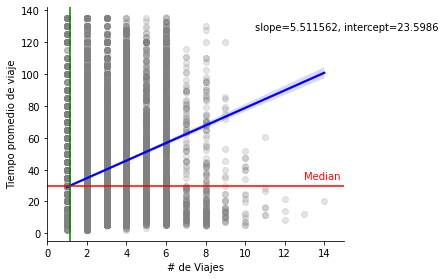

In [78]:
eod.plot_lmplot(n_viajes)

In [79]:
groups = eod.generate_groups(n_viajes)
print(eod.calculate_indicators(groups,'wt1_x'))

Generando grupo B2...
Generando grupo B1...
Generando grupo A1...
Generando grupo A2...
Generando grupo A3...
Generando grupo B3...
Generando grupo C...
Generando grupo D...
Tamaño población: 9177452.184782028
              Medida     Valor
0       (A1+A2+A3)/P  0.501140
1               A1/P  0.501140
2          (A2+A3)/P  0.000000
3               B3/P  0.000000
4               B1/P  0.000000
5               B2/P  0.397224
6                C/P  0.039647
7                D/P  0.061989
8            (C+D)/P  0.101637
9           <=15 min  0.257324
10  2 viajes diarios  0.638350


C:\Users\Usuario\anaconda3\envs\enmodo\lib\site-packages\seaborn\regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


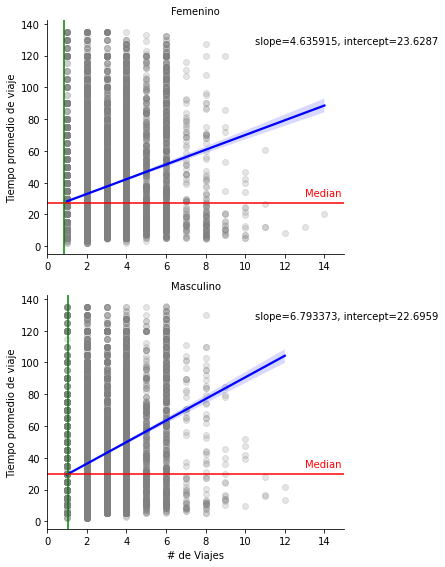

In [80]:
eod.plot_lmplot(n_viajes, col="SEXO", hue="SEXO", col_wrap=1)

In [81]:
subgroups = n_viajes.SEXO.unique()
for element in subgroups:
    print(element)
    groups = eod.generate_groups(n_viajes[n_viajes.SEXO==element])
    print(eod.calculate_indicators(groups,'wt1_x'))

Femenino
Generando grupo B2...
Generando grupo B1...
Generando grupo A1...
Generando grupo A2...
Generando grupo A3...
Generando grupo B3...
Generando grupo C...
Generando grupo D...
Tamaño población: 5089831.282936096
              Medida     Valor
0       (A1+A2+A3)/P  0.512938
1               A1/P  0.512938
2          (A2+A3)/P  0.000000
3               B3/P  0.000000
4               B1/P  0.000000
5               B2/P  0.410316
6                C/P  0.030624
7                D/P  0.046122
8            (C+D)/P  0.076746
9           <=15 min  0.268121
10  2 viajes diarios  0.588344
Masculino
Generando grupo B2...
Generando grupo B1...
Generando grupo A1...
Generando grupo A2...
Generando grupo A3...
Generando grupo B3...
Generando grupo C...
Generando grupo D...
Tamaño población: 4129832.489757538
              Medida     Valor
0       (A1+A2+A3)/P  0.109167
1               A1/P  0.109167
2          (A2+A3)/P  0.000000
3               B3/P  0.305833
4               B1/P  0.000000
5  

### Sin factor de expansión

In [ ]:
cantidad_viajes_etapa_por_sexo = viajes_gpd_etapa.groupby(['IDP_x', 'SEXO']).size()

In [ ]:
tiempo_prom_viajes_etapa_por_sexo = viajes_gpd_etapa.groupby(['IDP_x', 'SEXO']).mean('time_diff')['time_diff']

In [ ]:
cantidad_viajes_etapa_por_sexo = pd.DataFrame(cantidad_viajes_etapa_por_sexo)

In [ ]:
tiempo_prom_viajes_etapa_por_sexo = pd.DataFrame(tiempo_prom_viajes_etapa_por_sexo)

In [ ]:
n_viajes = pd.merge(cantidad_viajes_etapa_por_sexo, tiempo_prom_viajes_etapa_por_sexo, left_index=True, right_index=True)

In [ ]:
n_viajes.columns = ['n_viajes', 'tiempo_total']

In [ ]:
n_viajes['PONDERADOR_CALIBRADO'] = 1

In [ ]:
n_viajes.reset_index(inplace = True)

In [ ]:
x, y = symbols('x y')
eod.plot_lmplot(n_viajes)

In [ ]:
groups = eod.generate_groups(n_viajes)

In [ ]:
eod.plot_lmplot(n_viajes, col="SEXO", hue="SEXO", col_wrap=1)

In [ ]:
n_viajes.SEXO.unique()

In [ ]:
subgroups = n_viajes.SEXO.unique()
for element in subgroups:
    print(element)
    groups = eod.generate_groups(n_viajes[n_viajes.SEXO==element])
    print(eod.calculate_indicators(groups,'PONDERADOR_CALIBRADO'))

# Generación outputs

## Generación de csv

In [ ]:
viajes_gpd_hogares.shape

In [ ]:
viajes_gpd_etapa_hogares.shape

In [ ]:
viajes_gpd_hogares_to_save = viajes_gpd_hogares.drop(['geometry_origen', 'geometry_destino'], axis=1)


In [ ]:
viajes_gpd_hogares_to_save = pd.DataFrame(viajes_gpd_hogares_to_save)

In [ ]:
viajes_gpd_hogares_to_save.to_csv(data_path + 'buenos-aires/output-csv/viajes_gpd_hogares.csv', index=False)

In [ ]:
viajes_gpd_etapa_hogares_to_save = viajes_gpd_etapa_hogares.drop(['geometry_origen', 'geometry_destino'], axis=1)

In [ ]:
viajes_gpd_etapa_hogares_to_save = pd.DataFrame(viajes_gpd_etapa_hogares_to_save)

In [ ]:
viajes_gpd_etapa_hogares_to_save = viajes_gpd_etapa_hogares_to_save.loc[:,~viajes_gpd_etapa_hogares_to_save.columns.duplicated()]

In [ ]:
viajes_gpd_etapa_hogares_to_save = viajes_gpd_etapa_hogares_to_save.drop(['Unnamed: 0_x', 'HORAINI', 'HORAFIN', 'z_frecuenc_imput_x', 'Unnamed: 0_y', 'wt1_y', 'IDH_y',
                                       'IDP_y', 'Unnamed: 0_x', 'CDNINGUN', 'CDMOTORA', 'CDMENTAL', 'CDVISUAL', 'CDAUDITI', 'CDHABLA', 'CDOTRAS', 'z_cocherasino',
                                       'z_tieneciclomo', 'z_tienemoto', 'z_tieneauto', 'z_gastoco2', 'z_gastoma2', 'A pie', 'Automovil/acompañante', 'Automovil/conductor',
                                       'Bicicleta', 'Bus empresa', 'Charter/combi', 'Colectivo', 'Ferrocarril', 'Lancha Colectiva', 'Motocicleta', 'Otros', 'Remis', 'Subte/Premetro', 'Taxi', 'Transporte escolar', 'A demanda', 
                                       'Auto/Moto', 'No Motorizado', 'TIPOGARA', 'TIPOCOST', 'COSTOPEA', 'COSTOTAX', 'CUACAANT', 'CUACADES', 'ESPEHORA', 'ESPEMINU', 'DURAHORA', 'DURAMINU',
                                       'IDH_x', 'IDP_x', 'origen_x_coord', 'origen_y_coord', 'destino_x_coord', 'destino_y_coord'], axis=1)

In [ ]:
viajes_gpd_hogares_to_save.shape

In [ ]:
viajes_gpd_etapa_hogares_to_save.shape

In [ ]:
viajes_gpd_etapa_hogares_to_save.to_csv(data_path + 'buenos-aires/output-csv/viajes_gpd_etapa_hogares.csv', index=False)

## Generación de geojson

### viajes

In [ ]:
origenes_viajes = pd.DataFrame(viajes_gpd_hogares)
destinos_viajes = pd.DataFrame(viajes_gpd_hogares)

In [ ]:
origenes_viajes = gpd.GeoDataFrame(origenes_viajes, geometry='geometry_origen')
destinos_viajes = gpd.GeoDataFrame(destinos_viajes, geometry='geometry_destino')

In [ ]:
origenes_viajes.geometry_origen = origenes_viajes.geometry_origen.centroid
destinos_viajes.geometry_destino = destinos_viajes.geometry_destino.centroid

In [ ]:
origenes_viajes = origenes_viajes.loc[:,~origenes_viajes.columns.duplicated()]
destinos_viajes = destinos_viajes.loc[:,~destinos_viajes.columns.duplicated()]

In [ ]:
origenes_viajes.drop(['geometry_destino'], axis=1, inplace = True)
destinos_viajes.drop(['geometry_origen'], axis=1, inplace = True)

In [ ]:
origenes_viajes.to_file(data_path + 'output-geojson/origenes_viajes.geojson', driver='GeoJSON')
destinos_viajes.to_file(data_path + 'output-geojson/destinos_viajes.geojson', driver='GeoJSON')

### viajes_etapa

In [ ]:
origenes_viajes_etapa = pd.DataFrame(viajes_gpd_etapa_hogares)
destinos_viajes_etapa = pd.DataFrame(viajes_gpd_etapa_hogares)

In [ ]:
origenes_viajes_etapa = gpd.GeoDataFrame(origenes_viajes_etapa, geometry='geometry_origen')
destinos_viajes_etapa = gpd.GeoDataFrame(destinos_viajes_etapa, geometry='geometry_destino')

In [ ]:
origenes_viajes_etapa.geometry_origen = origenes_viajes_etapa.geometry_origen.centroid
destinos_viajes_etapa.geometry_destino = destinos_viajes_etapa.geometry_destino.centroid

In [ ]:
origenes_viajes_etapa = origenes_viajes_etapa.loc[:,~origenes_viajes_etapa.columns.duplicated()]
destinos_viajes_etapa = destinos_viajes_etapa.loc[:,~destinos_viajes_etapa.columns.duplicated()]

In [ ]:
origenes_viajes_etapa.drop(['geometry_destino'], axis=1, inplace = True)
destinos_viajes_etapa.drop(['geometry_origen'], axis=1, inplace = True)

In [ ]:
origenes_viajes_etapa.to_file(data_path + 'output-geojson/origenes_viajes_etapa.geojson', driver='GeoJSON')
destinos_viajes_etapa.to_file(data_path + 'output-geojson/destinos_viajes_etapa.geojson', driver='GeoJSON')

## Generación de shapefile

### viajes

In [ ]:
origenes_viajes.to_file(data_path + 'output-shp/origenes_viajes.shp', driver='GeoJSON')
destinos_viajes.to_file(data_path + 'output-shp/destinos_viajes.shp', driver='GeoJSON')

### viajes_etapa

In [ ]:
origenes_viajes_etapa.to_file(data_path + 'output-shp/origenes_viajes_etapa.shp', driver='GeoJSON')
destinos_viajes_etapa.to_file(data_path + 'output-shp/destinos_viajes_etapa.shp', driver='GeoJSON')